# Defensive Effects Visualization

This notebook loads a model with defensive effects and visualizes team defensive capabilities.

**Note**: Train models with defensive effects using:
```bash
python train_model.py --model static --data-dir ../Rugby-Data --include-defense --save-as defense_model
```

In [ ]:
from rugby_ranking.notebook_utils import setup_notebook_environment, load_model_and_trace

# Setup: load data and configure plots
dataset, df, model_dir = setup_notebook_environment()

## 1. Load Model with Defensive Effects

In [ ]:
# Load model checkpoint with defensive effects
CHECKPOINT_NAME = "defense_model"  # Or "latest" if trained with --include-defense
model, trace = load_model_and_trace(CHECKPOINT_NAME)

if not model.config.include_defense:
    print("\n⚠️  Warning: This model was not trained with defensive effects!")
    print("Train a new model with: python train_model.py --include-defense")

Loaded 14064 matches from ../../Rugby-Data/json
Found 13798 unique players
Found 224 unique teams
Loaded 437,211 observations
Players: 13,786
Teams: 153
Matches: 9,828


## 2. Load Data for Context

In [3]:
# Load data for context
DATA_DIR = Path("../../Rugby-Data")

dataset = MatchDataset(DATA_DIR, fuzzy_match_names=False)
dataset.load_json_files()
df = dataset.to_dataframe(played_only=True)

print(f"Data loaded: {len(df):,} observations")

## 3. Visualize Defensive Effects

In [26]:
# Extract defensive effects from trace
if "delta_defense" in trace.posterior:
    delta = trace.posterior["delta_defense"].values
    print(f"Defensive effects shape: {delta.shape}")
    print(f"Mean defensive effect: {delta.mean():.3f}")
    print(f"Range: [{delta.min():.3f}, {delta.max():.3f}]")
else:
    print("No defensive effects found in model")

Model built with defensive effects!
Variables: 47
Running VI (this may take 10-20 minutes)...


Output()

Finished [100%]: Average Loss = 2.4121e+05


✓ Model fitted!


### Alternative: Minibatch VI for Large Datasets

For datasets with >100k observations, use minibatch VI:

In [ ]:
# #For very large datasets, use minibatch model

# inference_config = InferenceConfig(
#     vi_n_iterations=250000,
#     vi_method="advi"
# )
# #model.build_joint(df)
# #model_mb = RugbyModel(config=config)
# model.build_joint_minibatch(df, minibatch_size=1024)

# fitter_mb = ModelFitter(model, config=inference_config)
# trace_mb = fitter_mb.fit_vi(progressbar=True)

# # Minibatch VI is typically 5-10x faster!

Output()

Finished [100%]: Average Loss = 200.54


## 4. Convergence Diagnostics

In [27]:
diagnostics = fitter_mb.diagnostics()
print("Convergence diagnostics:")
for key, value in diagnostics.items():
    print(f"  {key}: {value}")

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Convergence diagnostics:
  r_hat_max: nan
  r_hat_mean: nan
  ess_bulk_min: 1033.0
  ess_tail_min: 976.0
  divergences: 0
  fit_method: vi
  fit_time: 2026-01-17 23:53:06.717784


## 5. Offensive Rankings

Teams ranked by their ability to score tries:

In [20]:
trace = trace_mb

In [28]:
offensive_rankings = model.get_team_rankings(
    trace=trace,
    score_type="tries",
    season="2025-2026",
    top_n=200
)

print("Top 20 Offensive Teams (Try-Scoring):")
display(offensive_rankings)

Top 20 Offensive Teams (Try-Scoring):


,team,season,effect_mean,effect_std,effect_lower,effect_upper
0,All Blacks XV,2025-2026,0.865279,0.293544,0.311796,1.447304
1,Vannes,2025-2026,0.538937,0.085226,0.375831,0.705542
2,Biarritz,2025-2026,0.487197,0.088726,0.320409,0.661257
3,Oyonnax,2025-2026,0.470867,0.084757,0.306302,0.636039
4,Exeter Chiefs,2025-2026,0.424492,0.100148,0.227183,0.618968
...,...,...,...,...,...,...
77,Wales,2025-2026,-0.756212,0.316144,-1.381388,-0.137061
78,Cambridge,2025-2026,-0.773204,0.134676,-1.030409,-0.512178
79,British & Irish Lions,2025-2026,-0.883129,0.433501,-1.705507,-0.038699
80,Barbarians,2025-2026,-0.911661,0.362736,-1.634048,-0.222085


## 6. Defensive Rankings

NEW! Teams ranked by their ability to prevent opponent tries:

In [29]:
defensive_rankings = model.get_defensive_rankings(
    trace=trace,
    score_type="tries",
    season="2025-2026",
    top_n=200
)

print("Top 20 Defensive Teams (Try Prevention):")
print("(Higher defense_mean = better defense)")
display(defensive_rankings)

Top 20 Defensive Teams (Try Prevention):
(Higher defense_mean = better defense)


,team,season,defense_mean,defense_std,defense_lower,defense_upper
0,Colomiers,2025-2026,0.353245,0.138976,0.082663,0.635390
1,Vannes,2025-2026,0.075611,0.127151,-0.179878,0.322898
2,Dax,2025-2026,0.028914,0.121499,-0.207764,0.265335
3,Provence,2025-2026,0.017962,0.118729,-0.210976,0.243861
4,England,2025-2026,-0.012167,0.233848,-0.450558,0.442176
...,...,...,...,...,...,...
77,London Scottish,2025-2026,-1.192029,0.099865,-1.380370,-0.996908
78,Coventry,2025-2026,-1.227870,0.109342,-1.450693,-1.015470
79,Montauban,2025-2026,-1.249659,0.072670,-1.396186,-1.109965
80,Ampthill,2025-2026,-1.431576,0.090056,-1.613415,-1.259532


## 7. Offense vs Defense Comparison

Which teams are balanced? Which are offense-heavy or defense-heavy?

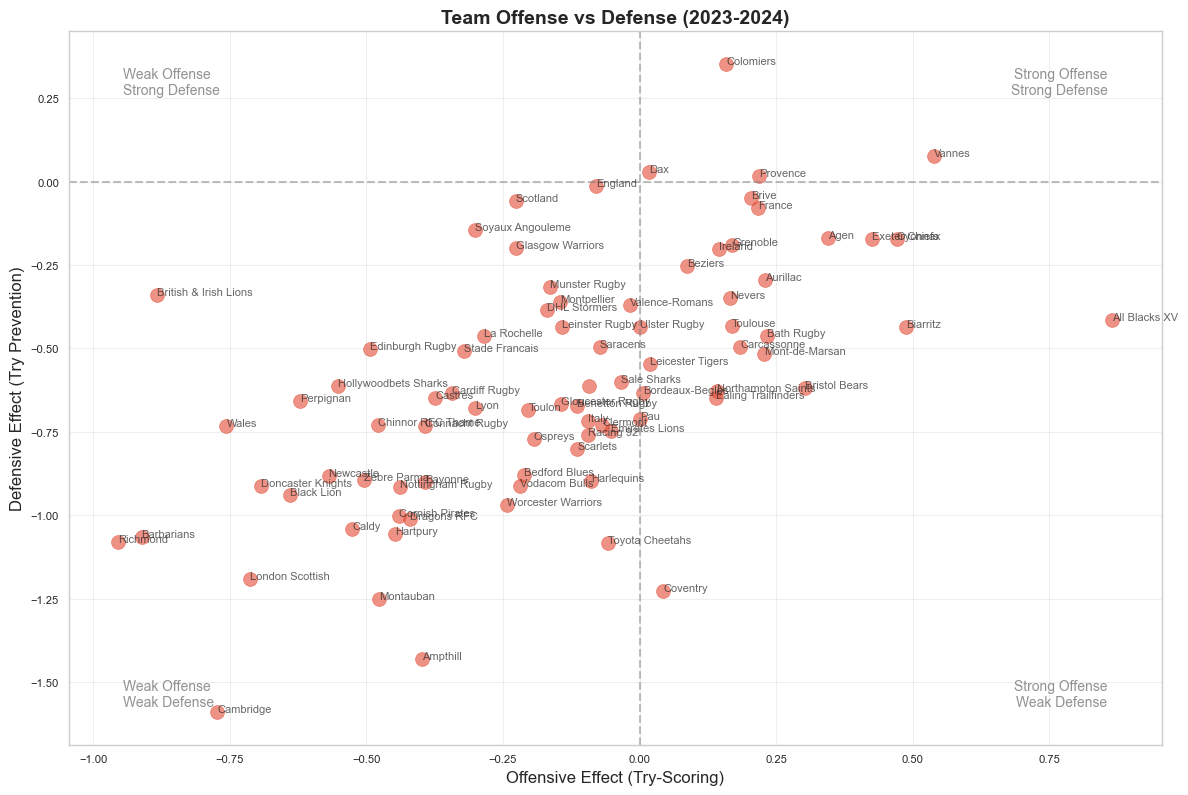

In [30]:
# Merge offensive and defensive rankings
comparison = offensive_rankings[['team', 'season', 'effect_mean']].merge(
    defensive_rankings[['team', 'season', 'defense_mean']],
    on=['team', 'season'],
    how='inner'
)

comparison.columns = ['team', 'season', 'offense', 'defense']

# Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(comparison['offense'], comparison['defense'], s=100, alpha=0.6)

# Add team labels
for _, row in comparison.iterrows():
    ax.annotate(
        row['team'],
        (row['offense'], row['defense']),
        fontsize=8,
        alpha=0.7
    )

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Offensive Effect (Try-Scoring)', fontsize=12)
ax.set_ylabel('Defensive Effect (Try Prevention)', fontsize=12)
ax.set_title('Team Offense vs Defense (2023-2024)', fontsize=14, fontweight='bold')

# Add quadrant labels
ax.text(0.95, 0.95, 'Strong Offense\nStrong Defense', 
        transform=ax.transAxes, ha='right', va='top', fontsize=10, alpha=0.5)
ax.text(0.05, 0.95, 'Weak Offense\nStrong Defense',
        transform=ax.transAxes, ha='left', va='top', fontsize=10, alpha=0.5)
ax.text(0.95, 0.05, 'Strong Offense\nWeak Defense',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=10, alpha=0.5)
ax.text(0.05, 0.05, 'Weak Offense\nWeak Defense',
        transform=ax.transAxes, ha='left', va='bottom', fontsize=10, alpha=0.5)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Player Rankings

Player effects work as before:

In [35]:
pd.set_option('display.max_rows', None)

In [36]:
player_rankings = model.get_player_rankings(
    trace=trace,
    score_type="tries",
    top_n=200
)

print("Top 20 Try-Scorers (Player Effects):")
display(player_rankings, )

Top 20 Try-Scorers (Player Effects):


,player,effect_mean,effect_std,effect_lower,effect_upper
0,Ed Byrne,1.724163,0.197354,1.333805,2.111907
1,Rob Evans,1.608738,0.161469,1.307613,1.940161
2,S Simmonds,1.554296,0.148448,1.263188,1.839478
3,Reinach Venter,1.531426,0.376152,0.802273,2.263833
4,Thomas Moukoro,1.524428,0.276644,0.995512,2.079999
5,Baptiste Couilloud,1.186934,0.135050,0.917386,1.456737
6,Max Williams,1.153348,0.382774,0.392878,1.904729
7,Mako Vunipola,1.151824,0.144056,0.871266,1.428495
8,Thomas du Toit,1.146173,0.227002,0.703472,1.583442
9,Dylan Evans,1.131827,0.335696,0.479091,1.785053


In [37]:
def show_rankings(score_type, top_n=20):
    """Display top players for a given score type."""
    rankings = model.get_player_rankings(trace=fitter.trace, top_n=top_n, score_type=score_type)
    print(f"\nTop {top_n} {score_type.capitalize()} Players:")
    display(rankings)
    return rankings

penalty_rankings = show_rankings('penalties', top_n=20)
#conversion_rankings = show_rankings('conversions', top_n=20)


Top 20 Penalties Players:


,player,effect_mean,effect_std,effect_lower,effect_upper
0,Joseph Davies,7.939174,0.174689,7.583774,8.296560
1,Ed Byrne,7.720362,0.098691,7.518421,7.913427
2,S Simmonds,7.199635,0.103911,7.000450,7.399988
3,JP Cooney,7.148600,0.394581,6.354728,7.919419
4,Joe Davies,7.044438,0.173694,6.705260,7.387862
5,Daniel Du Preez,6.775418,0.152485,6.485020,7.076070
6,Taylor Davies,6.668927,0.240359,6.211787,7.135915
7,Wyn Jones,6.558118,0.149246,6.273665,6.856760
8,Mornay Smith,6.554426,0.249520,6.043859,7.022101
9,Garin Jenkins,6.504762,0.315898,5.885969,7.119708


## 9. Save Model

Save the fitted model for later use:

In [ ]:
checkpoint_path = fitter.save("joint_model_v3")
print(f"Model saved to: {checkpoint_path}")

Saved checkpoint to /home/daniel/.cache/rugby_ranking/joint_model_v3
Model saved to: /home/daniel/.cache/rugby_ranking/joint_model_v3


: 

## 10. Model Comparison

Compare predictions with and without defensive effects:

In [25]:
# Fit model WITHOUT defensive effects for comparison
config_no_def = ModelConfig(
    include_defense=False,
    separate_kicking_effect=True
)

model_no_def = RugbyModel(config=config_no_def)
model_no_def.build_joint_minibatch(df, minibatch_size=1024)

fitter_no_def = ModelFitter(model_no_def, config=inference_config)
trace_no_def = fitter_no_def.fit_vi(progressbar=True, random_seed=42)

# Compare team rankings
rankings_no_def = model_no_def.get_team_rankings(
    trace=trace_no_def,
    score_type="tries",
    season="2023-2024",
    top_n=20
)

print("\nEffect of adding defensive component:")
print("(Positive value = team ranked higher with defense model)")

rank_comparison = offensive_rankings[['team', 'effect_mean']].merge(
    rankings_no_def[['team', 'effect_mean']],
    on='team',
    suffixes=('_with_def', '_no_def')
)

rank_comparison['difference'] = (
    rank_comparison['effect_mean_with_def'] - 
    rank_comparison['effect_mean_no_def']
)

rank_comparison = rank_comparison.sort_values('difference', ascending=False)
display(rank_comparison)

Output()

Interrupted at 5,113 [2%]: Average Loss = 2.1081e+05



Effect of adding defensive component:
(Positive value = team ranked higher with defense model)


,team,effect_mean_with_def,effect_mean_no_def,difference
0,France,0.174473,-0.012301,0.186774
3,Barbarians,0.001235,-0.060193,0.061429
5,Emirates Lions,-0.001009,-0.002962,0.001953
2,Black Lion,0.001484,0.001618,-0.000134
18,Benetton Rugby,-0.048707,-0.043827,-0.004880
6,Toyota Cheetahs,-0.004049,0.008065,-0.012113
8,DHL Stormers,-0.007812,0.007759,-0.015572
11,Edinburgh Rugby,-0.025491,-0.000773,-0.024718
13,England,-0.033476,-0.003835,-0.029641
14,Soyaux Angouleme,-0.038240,-0.004207,-0.034033


## Summary

### New Features Demonstrated:

1. **Defensive Effects** (`include_defense=True`)
   - Teams have both offensive and defensive ratings
   - Opponent defense reduces your scoring rate
   - Access via `model.get_defensive_rankings()`

2. **Minibatch VI** (`build_joint_minibatch()`)
   - 5-10x faster for large datasets
   - Uses stochastic gradients
   - Configure with `minibatch_size` parameter

3. **Improved Interpretability**
   - Separate offensive and defensive team strengths
   - Better match predictions (accounts for opponent quality)
   - Identifies balanced vs specialized teams

### Configuration Options:

```python
ModelConfig(
    include_defense=True,          # Enable defensive effects
    defense_effect_sd=0.3,         # Prior for defense strength
    separate_kicking_effect=True   # Separate try/kick abilities
)

InferenceConfig(
    vi_use_minibatch=True,         # Enable minibatch VI
    vi_minibatch_size=1024         # Batch size
)
```